In [144]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# SSD Optimizer

In [29]:
num_vars = 7
num_classes = 3
num_anchors = 5
batch_size = 3

sess = tf.Session()

def tf_print(tensor):
    print(sess.run(tensor))

## Ground truth

In [108]:
# Classificatin tensor
# shape: (batch_size, num_anchors, num_classes)
# create random label input
gt_cl = []
for i in range(batch_size):
    x = np.eye(num_classes)
    # select row at random choice
    gt_cl.append(x[np.random.choice(x.shape[0], size=num_anchors)].tolist())
gt_cl = tf.constant(gt_cl)


# Localization tensor
# shape: (batch_size, num_anchors, 4) 
gt_loc = tf.constant([[[ 0.3869008,   0.2889062,   0.2838913,   0.47948352],
  [-1.1316028,   0.29714587,  0.6015586,   0.3729462 ],
  [-1.0588769,  -0.25315255, -0.34880033, -0.59850043],
  [ 1.114877,   -0.4919945,  -1.3831943,   0.18301326],
  [-0.06354824,  0.01563287, -1.6393721,   0.70654845]],

 [[ 0.05637494,  0.26780865, -1.2404562,   1.1448557 ],
  [-0.805728,    0.3200344,  -0.64203537,  1.2978855 ],
  [-1.2355933,   0.7456697,   0.7035232,  -1.6139536 ],
  [-1.1935058,  -0.5659212, -0.27643606, -1.4432042 ],
  [-0.61198777, -0.24967131, -1.5702643,   1.5619597 ]],

 [[-0.685509,    0.00893273,  0.7638878,  -0.17860977],
  [-0.36306795, -0.78268015, -2.3794832,   0.18845686],
  [-0.51379865,  0.00920411,  0.79405373, -1.6149945 ],
  [ 0.5305107,   0.8555886,  -0.43728977, -1.2831309 ],
  [-0.82253236,  0.23744683,  0.38302115, -0.34826276]]])

# Senity check
tf_print(gt_cl)
tf_print(gt_loc)

[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 1. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  [0. 0. 1.]]

 [[0. 1. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
[[[ 0.3869008   0.2889062   0.2838913   0.47948352]
  [-1.1316028   0.29714587  0.6015586   0.3729462 ]
  [-1.0588769  -0.25315255 -0.34880033 -0.59850043]
  [ 1.114877   -0.4919945  -1.3831943   0.18301326]
  [-0.06354824  0.01563287 -1.6393721   0.70654845]]

 [[ 0.05637494  0.26780865 -1.2404562   1.1448557 ]
  [-0.805728    0.3200344  -0.64203537  1.2978855 ]
  [-1.2355933   0.7456697   0.7035232  -1.6139536 ]
  [-1.1935058  -0.5659212  -0.27643606 -1.4432042 ]
  [-0.61198777 -0.24967131 -1.5702643   1.5619597 ]]

 [[-0.685509    0.00893273  0.7638878  -0.17860977]
  [-0.36306795 -0.78268015 -2.3794832   0.18845686]
  [-0.51379865  0.00920411  0.79405373 -1.6149945 ]
  [ 0.5305107   0.8555886  -0.43728977 -1.2831309 ]
  [-0.82253236  0.23744683  0.38302115 -0.34826276]]]


# Classification Loss
## match_counters

In [109]:
# Number of anchors per sample
# Shape: (batch_size) 
total_num = tf.ones([batch_size], dtype=tf.int64) * tf.to_int64(num_anchors)

# Number of negative (not-matched) anchors per sample, computed by  
# counting boxes of the background class in each sample.            
# Shape: (batch_size) 
negatives_num = tf.count_nonzero(gt_cl[:, :, -1], axis=1)

# Number of positive (matched) anchors per sample                   
# Shape: (batch_size)
positives_num = total_num - negatives_num

# senity check
print("Number of anchors per batch")
print("Total: \n", sess.run(total_num))
print("Negative (bg=1): \n", sess.run(negatives_num))
print("Positive (bg!=1): \n",sess.run(positives_num))

Number of anchors per batch
Total: 
 [5 5 5]
Negative (bg=1): 
 [2 1 1]
Positive (bg!=1): 
 [3 4 4]


In [110]:
# Number of positives per sample that is division-safe              
# Shape: (batch_size)                                               
positives_num_safe = tf.where(tf.equal(positives_num, 0),           
                              tf.ones([batch_size])*10e-15,         
                              tf.to_float(positives_num))
tf_print(positives_num_safe)

[3. 4. 4.]


## match_masks

In [111]:
# Boolean tensor determining whether an anchor is a positive        
# Shape: (batch_size, num_anchors)  
positives_mask = tf.equal(gt_cl[:, :, -1], 0)
print("Positive mask:")
print(sess.run(positives_mask))

# Boolean tensor determining whether an anchor is a negative        
negatives_mask = tf.logical_not(positives_mask)
print("Negative mask:")
tf_print(negatives_mask)

Positive mask:
[[ True  True False False  True]
 [ True  True  True  True False]
 [ True  True  True  True False]]
Negative mask:
[[False False  True  True False]
 [False False False False  True]
 [False False False False  True]]


## confidence_loss

In [112]:
# Cross-entorpy tensor  (gt_cl => logits)                                        
# Shape: (batch_size, num_anchors) 
conf = tf.constant([[0.39282098, 0.4600574,  0.01153591, 0.14568441, 0.85366163],
                    [0.33491521, 0.18863397, 0.18936157, 0.18933312, 0.09754541],
                    [0.71655552, 0.89165631, 0.28296348, 0.45780019, 0.41719255]])
tf_print(conf)

[[0.39282098 0.4600574  0.01153591 0.1456844  0.85366166]
 [0.33491522 0.18863396 0.18936157 0.18933313 0.09754541]
 [0.71655554 0.89165634 0.28296348 0.45780018 0.41719255]]


In [113]:
# Sum up the loss of all the positive anchors                       
# Positives - the loss of neg anchors is zeroed out                 
# Shape: (batch_size, num_anchors) 
positives_conf = tf.where(positives_mask, conf, tf.zeros_like(conf))
tf_print(positives_conf)

[[0.39282098 0.4600574  0.         0.         0.85366166]
 [0.33491522 0.18863396 0.18936157 0.18933313 0.        ]
 [0.71655554 0.89165634 0.28296348 0.45780018 0.        ]]


In [114]:
# Total loss of positive anchors                                    
# Shape: (batch_size)                                               
positives_sum = tf.reduce_sum(positives_conf, axis=-1)
tf_print(positives_sum)

[1.7065401 0.9022439 2.3489757]


In [115]:
# Find neg anchors with highest conf loss                           
# Negatives - the loss of positive anchor is zeroed out             
# Shape: (batch_size, num_anchors)                                  
negatives_conf = tf.where(negatives_mask, conf, tf.zeros_like(conf))
tf_print(negatives_conf)

[[0.         0.         0.01153591 0.1456844  0.        ]
 [0.         0.         0.         0.         0.09754541]
 [0.         0.         0.         0.         0.41719255]]


In [116]:
# Top neg - sorted conf loss with highest one first                 
# Shape: (batch_size, num_anchors)
negatives_top = tf.nn.top_k(negatives_conf, num_anchors)[0]
tf_print(negatives_top)

[[0.1456844  0.01153591 0.         0.         0.        ]
 [0.09754541 0.         0.         0.         0.        ]
 [0.41719255 0.         0.         0.         0.        ]]


In [117]:
# Find num of negs we want to keep are                              
# Max num of negs to keep per sample - keep 3 time as many as pos   
# anchors in the sample                                             
# Shape: (batch_size) 
negatives_num_max = tf.minimum(negatives_num, 3*positives_num)
tf_print(negatives_num_max)

[2 1 1]


In [118]:
# mask out superfluous negs and compute the sum of the loss         
# Transposed vector of maximum negs per sample                      
# Shape: (batch_size, 1)                                            
negatives_num_max_t = tf.expand_dims(negatives_num_max, 1)
tf_print(negatives_num_max_t)

[[2]
 [1]
 [1]]


In [119]:
# Range tensor: [0, 1, 2, ..., num_anchors-1]                       
# Shape: (num_anchors)                                              
rng = tf.range(0, num_anchors, 1)
tf_print(rng)

[0 1 2 3 4]


In [120]:
# Row range, int64, row of a matrix                                 
# shape: (1, num_anchors)                                           
range_row = tf.to_int64(tf.expand_dims(rng, 0)) 
tf_print(range_row)

[[0 1 2 3 4]]


In [121]:
# Mask of maximum negatives - first `negative_num_max` elements     
# in corresponding row are `True`, the rest is false                
# Shape: (batch_size, num_anchors)
negatives_max_mask = tf.less(range_row, negatives_num_max_t)
tf_print(negatives_max_mask)

[[ True  True False False False]
 [ True False False False False]
 [ True False False False False]]


In [122]:
# Max negatives - all the positives and superfluous negatives are zeroed out.                                                       
# Shape: (batch_size, num_anchors)                     
negatives_max = tf.where(negatives_max_mask, negatives_top, tf.zeros_like(negatives_top))
tf_print(negatives_max)

[[0.1456844  0.01153591 0.         0.         0.        ]
 [0.09754541 0.         0.         0.         0.        ]
 [0.41719255 0.         0.         0.         0.        ]]


In [123]:
# Sum of max negatives for each sample                              
# Shape: (batch_size)                                               
negatives_max_sum = tf.reduce_sum(negatives_max, axis=-1) 
tf_print(negatives_max_sum)

[0.15722032 0.09754541 0.41719255]


## Compute the confidence loss for each element 

In [124]:
# Total confidence loss for each sample                             
# Shape: (batch_size) 
confidence_loss = tf.add(positives_sum, negatives_max_sum)
tf_print(confidence_loss)

[1.8637605 0.9997893 2.766168 ]


In [125]:
# Mean confidence loss for the batch                                
# Shape: scalar                                                     
batch_confidence_loss = tf.reduce_mean(confidence_loss, name='confidence_loss')
tf_print(batch_confidence_loss)

1.8765726


# Localization Loss

In [126]:
# fake locator
locator = tf.constant([[[-0.08690866,  0.42891535,  0.90692073, -1.000208,  ],
  [ 0.08887938,  0.7338174,  -2.1127641,   0.212139  ],
  [-1.4964243,   0.99155605,  1.296262,   -0.88467544],
  [-1.3028897,  -1.9386891,  -0.42265242,  0.07432887],
  [-1.2400016,  -1.4654435,   0.36970618, -0.53925747]],

 [[ 0.12611438, -0.5367207,  -0.21797356, -0.5519516 ],
  [ 1.406873,  -1.0025243,  -3.4703248,  -0.791926  ],
  [ 0.2637903,  -0.662972,   -0.88780755,  0.70007133],
  [-0.78875697,  0.40680915,  2.215111,   -0.3220501 ],
  [-0.618558,   -1.5095842,  -1.3640805,  -0.90787244]],

 [[ 0.01366237,  0.9057503,   0.9853926,   0.7723707 ],
  [-1.0289191,  -0.22524424,  0.58269465, -0.9648252 ],
  [-1.0404605,  -0.46937886,  0.67090863, -0.53685075],
  [ 0.61732346, -0.96537924,  0.2936782,   0.15509798],
  [ 0.34775734,  0.05252579,  0.56725425, -0.8486104]]])

In [129]:
# Element-wise difference btw the predicted localization and ground truth                   
# Shape: (batch, num_anchors, 4)
loc_diff = tf.subtract(locator, gt_loc)
tf_print(loc_diff)

[[[-0.47380948  0.14000916  0.6230295  -1.4796915 ]
  [ 1.2204821   0.43667153 -2.7143228  -0.1608072 ]
  [-0.43754745  1.2447085   1.6450623  -0.286175  ]
  [-2.4177666  -1.4466946   0.9605419  -0.10868439]
  [-1.1764534  -1.4810764   2.0090783  -1.245806  ]]

 [[ 0.06973945 -0.8045293   1.0224826  -1.6968074 ]
  [ 2.212601   -1.3225586  -2.8282895  -2.0898116 ]
  [ 1.4993837  -1.4086417  -1.5913308   2.314025  ]
  [ 0.4047488   0.97273034  2.491547    1.1211541 ]
  [-0.00657022 -1.2599128   0.20618379 -2.4698322 ]]

 [[ 0.6991714   0.89681756  0.22150475  0.9509805 ]
  [-0.6658511   0.5574359   2.9621778  -1.153282  ]
  [-0.5266618  -0.47858298 -0.1231451   1.0781438 ]
  [ 0.08681273 -1.8209679   0.730968    1.4382288 ]
  [ 1.1702898  -0.18492104  0.1842331  -0.5003476 ]]]


In [192]:
def smooth_l1_loss(x):                                                          
    square_loss = 0.5 * x**2                                                    
    absolute_loss = tf.abs(x)                                                   
    return tf.where(tf.less(absolute_loss, 1.), square_loss, absolute_loss-0.5)

def l1_loss(x):
    return tf.abs(x)

def l2_loss(x):
    return tf.square(x)

def sort_tensor(x):
    x = sess.run(x)
    x = tf.constant(np.sort(x))
    return x

In [193]:
# Smooth L1 loss                  
# Shape: (batch_size, num_anchors, 4)
loc_loss = smooth_l1_loss(loc_diff)
tf_print(loc_loss)

[[[1.1224771e-01 9.8012835e-03 1.9408286e-01 9.7969151e-01]
  [7.2048211e-01 9.5341012e-02 2.2143228e+00 1.2929479e-02]
  [9.5723882e-02 7.4470854e-01 1.1450623e+00 4.0948071e-02]
  [1.9177666e+00 9.4669461e-01 4.6132037e-01 5.9061483e-03]
  [6.7645335e-01 9.8107636e-01 1.5090783e+00 7.4580598e-01]]

 [[2.4317952e-03 3.2363370e-01 5.2248263e-01 1.1968074e+00]
  [1.7126009e+00 8.2255864e-01 2.3282895e+00 1.5898116e+00]
  [9.9938369e-01 9.0864170e-01 1.0913308e+00 1.8140249e+00]
  [8.1910796e-02 4.7310215e-01 1.9915471e+00 6.2115407e-01]
  [2.1583895e-05 7.5991285e-01 2.1255879e-02 1.9698322e+00]]

 [[2.4442033e-01 4.0214089e-01 2.4532177e-02 4.5218194e-01]
  [2.2167885e-01 1.5536740e-01 2.4621778e+00 6.5328205e-01]
  [1.3868633e-01 1.1452083e-01 7.5823581e-03 5.7814384e-01]
  [3.7682254e-03 1.3209679e+00 2.6715711e-01 9.3822885e-01]
  [6.7028975e-01 1.7097896e-02 1.6970918e-02 1.2517387e-01]]]


### Compare Smooth L1, L1, L2

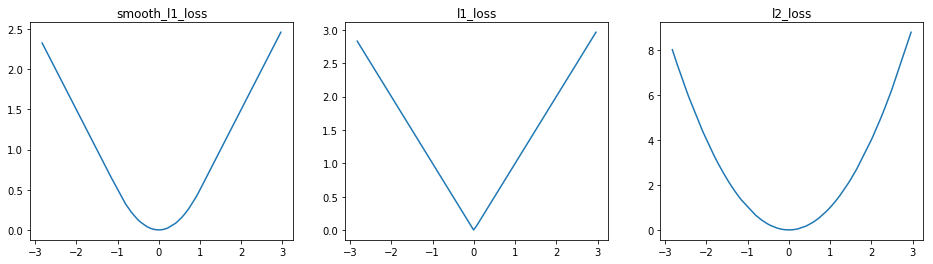

In [194]:
loss_fns = [smooth_l1_loss, l1_loss, l2_loss]

fig = plt.figure(figsize=(16, 4))
for i, loss_fn in enumerate(loss_fns):
    plt.subplot(1,3, i+1)
    x = tf.reshape(loc_diff, [-1])
    x = sort_tensor(x)
    y = loss_fn(x)
    x, y = sess.run([x, y])
    plt.plot(x, y)
    plt.title(loss_fn.__name__)
plt.show()

In [141]:
# Sum of localization losses for each anchor
# Shape: (batch_size, num_anchors)
loc_loss_sum = tf.reduce_sum(loc_loss, axis=-1)
tf_print(loc_loss_sum)

[[1.2958233  3.0430753  2.0264428  3.3316877  3.9124138 ]
 [2.0453556  6.4532604  4.813381   3.167714   2.7510223 ]
 [1.1232753  3.492506   0.83893335 2.530122   0.82953244]]


In [143]:
# Positive locs - the loss of negative anchors is zeroed >
# Shape: (batch_size, num_anchors)
positive_locs = tf.where(positives_mask, loc_loss_sum, tf.zeros_like(loc_loss_sum))
tf_print(positive_locs)
tf_print(positives_mask)

[[1.2958233  3.0430753  0.         0.         3.9124138 ]
 [2.0453556  6.4532604  4.813381   3.167714   0.        ]
 [1.1232753  3.492506   0.83893335 2.530122   0.        ]]
[[ True  True False False  True]
 [ True  True  True  True False]
 [ True  True  True  True False]]


In [195]:
# Total loss of positive anchors                                    
# Shape: (batch_size)                                               
localization_loss = tf.reduce_sum(positive_locs, axis=-1)
tf_print(localization_loss)

[ 8.251312  16.479712   7.9848366]


In [198]:
# Total localization loss normalized by the number of positives per sample                                                        
# Shape: (batch_size)                                               
localization_loss = tf.where(tf.equal(positives_num, 0),            
                         tf.zeros([batch_size]), tf.div(localization_loss, positives_num_safe)
                            )
tf_print(localization_loss)
tf_print(positives_num)
tf_print(positives_num_safe)

[0.30560416 0.2574955  0.12476307]
[3 4 4]
[3. 4. 4.]


In [199]:
# Mean confidence loss for the batch                                
# Shape: scalar                                                     
confidence_loss = tf.reduce_mean(confidence_loss, name='confidence_loss')
tf_print(confidence_loss)

1.8765726
